In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
eps = 0.001
max_c = 10
max_n = 100

In [3]:
num_classes = 10

In [4]:
model_name = '50'

In [5]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
def load_model(model_name):
    model = model_from_json(open(f'models/{model_name}_model.json').read())
    model.load_weights(f'weights/{model_name}_weights.h5')

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    return model

In [7]:
def predict(x, model_name):
    model = load_model(model_name)
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [8]:
def generate_grads(x, label, model_name):
    
    model = load_model(model_name)
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(32,32,3)

In [9]:
def generate_adv(x, label, model_name, eps):
    x = x.reshape(32,32,3)
    p = np.sign(generate_grads(x, label, model_name))
    adv = (x - eps*p).clip(min=0, max=1)
    
    return adv

In [10]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 10 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [11]:
def generate_it_adv(x, label, model_name, eps, max_c):
    c = 0
    adv = x.reshape(32,32,3)
    
    model = load_model(model_name)
    
    pred = model.predict(np.array([adv]), batch_size=1)[0]
    idx_sorted = np.argsort(pred)[::-1]
    first_class = int(idx_sorted[0])
    second_class = int(idx_sorted[1])
    
#     print(f'1: {first_class}, {pred[first_class]}')
#     print(f'2: {second_class}, {pred[second_class]}')
#     print('----------------------')
        
    while (first_class == label) and (c < max_c):
        c += 1
#         print('it_adv c: ', c)
        g = generate_grads(adv, second_class, model_name)
        adv = (adv + eps*np.sign(g)).clip(min=0, max=1).reshape(32,32,3)
        
        model = load_model(model_name)
        
        pred = model.predict(np.array([adv]), batch_size=1)[0]
        idx_sorted = np.argsort(pred)[::-1]
        first_class = int(idx_sorted[0])
        second_class = int(idx_sorted[1])
        
#         print(f'1: {first_class}, {pred[first_class]}')
#         print(f'2: {second_class}, {pred[second_class]}')
#         print('----------------------')
        
    return adv

In [12]:
def generate_it_adv_list(x_list, y_list, model_name, eps, max_c):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 10 == 0:
            print(i)
        adv = generate_it_adv(x, y, model_name, eps, max_c)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [13]:
def generate_i_adv(x, label, model_name, eps, max_c):
    c = 1
#     print('i_adv c: ', c)
    
    g = generate_grads(x, label, model_name)
    adv = (x - eps*np.sign(g)).clip(min=0, max=1).reshape(32,32,3)
    
    model = load_model(model_name)
    
    pred = model.predict(np.array([adv]), batch_size=1)[0]
    idx_sorted = np.argsort(pred)[::-1]
    first_class = int(idx_sorted[0])
    
#     print(f'1: {first_class}, {pred[first_class]}')
#     print('----------------------')
        
    while (first_class == label) and (c < max_c):
        c += 1
#         print('i_adv c: ', c)
        g = generate_grads(adv, label, model_name)
        adv = (adv - eps*np.sign(g)).clip(min=0, max=1).reshape(32,32,3)
        
        model = load_model(model_name)
        
        pred = model.predict(np.array([adv]), batch_size=1)[0]
        idx_sorted = np.argsort(pred)[::-1]
        first_class = int(idx_sorted[0])
        
#         print(f'1: {first_class}, {pred[first_class]}')
#         print('----------------------')
        
    return adv

In [14]:
def generate_i_adv_list(x_list, y_list, model_name, eps, max_c):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 10 == 0:
            print(i)
        adv = generate_i_adv(x, y, model_name, eps, max_c)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [15]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

In [16]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [17]:
adv_test = generate_adv_list(x_test[:max_n], y_test[0:max_n], model_name, eps*max_c)
adv_test.shape

W0114 22:33:18.740695 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0114 22:33:18.769648 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0114 22:33:18.814385 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0114 22:33:18.820463 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0114 

0


W0114 22:33:19.039906 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0114 22:33:19.153121 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



10
20
30
40
50
60
70
80
90


(100, 32, 32, 3)

In [18]:
it_adv_test = generate_it_adv_list(x_test[:max_n], y_test[0:max_n], model_name, eps, max_c)
it_adv_test.shape

0
10
20
30
40
50
60
70
80
90


(100, 32, 32, 3)

In [19]:
i_adv_test = generate_i_adv_list(x_test[:max_n], y_test[0:max_n], model_name, eps, max_c)
i_adv_test.shape

0
10
20
30
40
50
60
70
80
90


(100, 32, 32, 3)

In [20]:
model = load_model(model_name)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [21]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.6737617537498474
Test accuracy : 0.8067


x


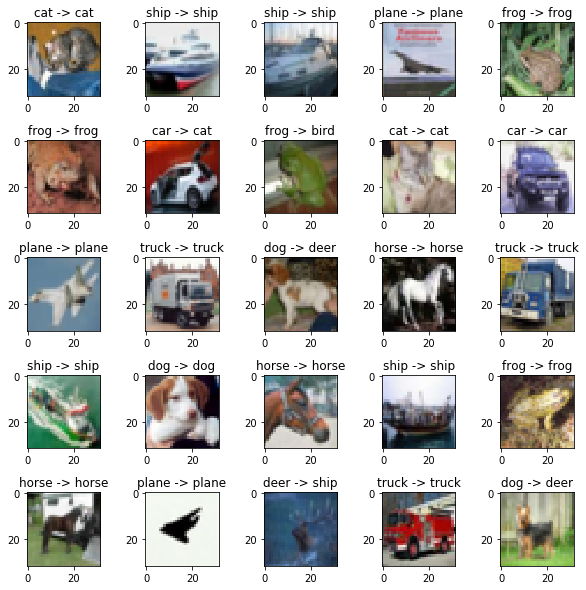

In [22]:
print('x')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = x_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

In [23]:
score = model.evaluate(x_test[:max_n], y_test_catego[:max_n], verbose=0)
print('x')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

x
Test loss : 0.7084791827201843
Test accuracy : 0.8


In [24]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv
Test loss : 3.8170055389404296
Test accuracy : 0.3


adv


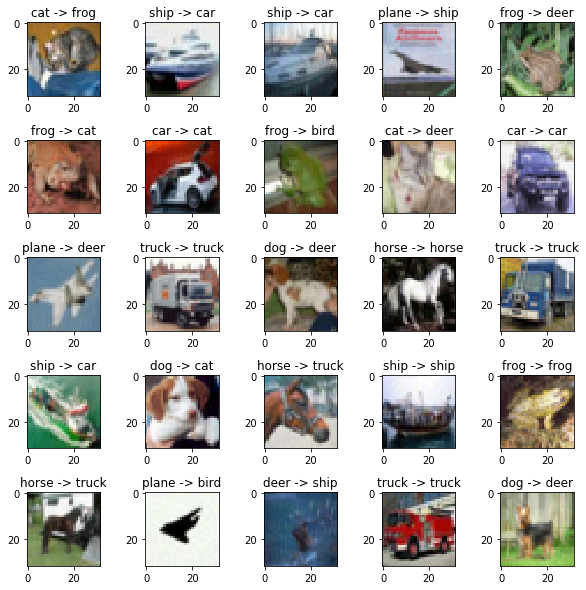

In [25]:
print('adv')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

In [26]:
score = model.evaluate(it_adv_test, y_test_catego[:max_n], verbose=0)
print('it_adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

it_adv
Test loss : 1.269771604537964
Test accuracy : 0.22


it_adv


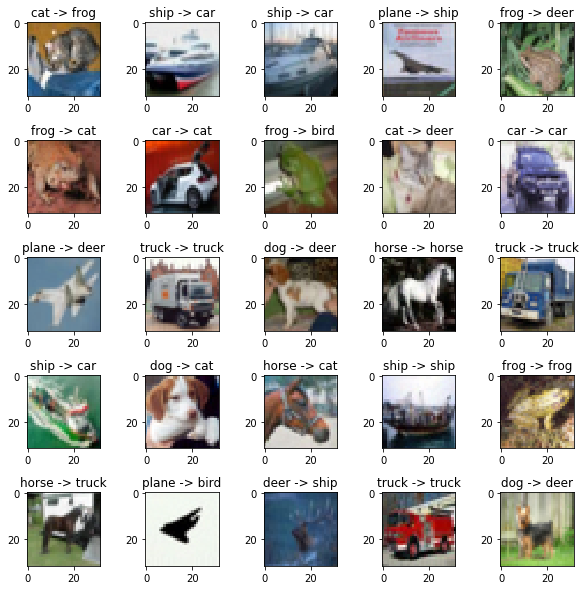

In [27]:
print('it_adv')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = it_adv_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

In [28]:
score = model.evaluate(i_adv_test, y_test_catego[:max_n], verbose=0)
print('i_adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

i_adv
Test loss : 1.5264214086532593
Test accuracy : 0.23


i_adv


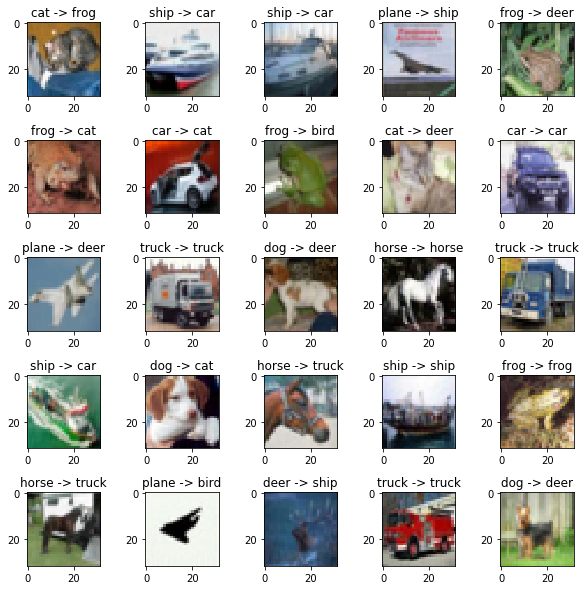

In [29]:
print('i_adv')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = i_adv_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

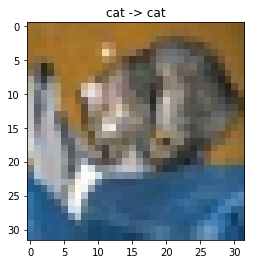

In [30]:
idx = 0
x = x_test[idx]
y = int(y_test[idx])

pred_class, pred_per = predict(x, model_name)
plt.imshow(x)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()

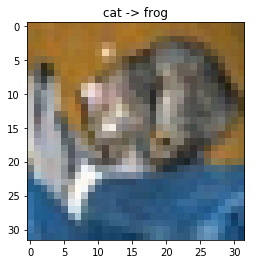

In [31]:
adv = adv_test[idx]

pred_class, pred_per = predict(adv, model_name)
plt.imshow(adv)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()

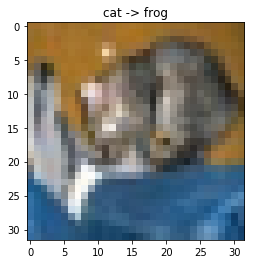

In [32]:
it_adv = it_adv_test[idx]

pred_class, pred_per = predict(it_adv, model_name)
plt.imshow(it_adv)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()

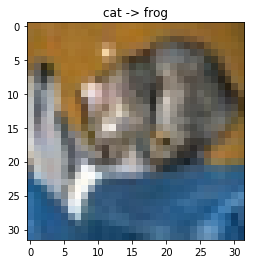

In [33]:
i_adv = i_adv_test[idx]

pred_class, pred_per = predict(i_adv, model_name)
plt.imshow(i_adv)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()